<a href="https://www.kaggle.com/gautammdiwan/doing-linear-regresssion-using-rapids?scriptVersionId=88962292" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
from IPython.display import clear_output

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,GridSearchCV

In [4]:
import cudf as cd
import cupy as cp
from cuml.preprocessing.LabelEncoder import LabelEncoder
# from cuml.experimental.preprocessing import StandardScaler
from cuml import PCA,Ridge,LinearRegression,Lasso,ElasticNet
from cuml.model_selection import train_test_split
from cuml.metrics.regression import mean_squared_error,mean_absolute_error,r2_score

In [5]:
df_train = cd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = cd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,MnPrv,<NA>,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,4,2010,WD,Normal,142125


In [6]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,<NA>,Reg,Lvl,AllPub,...,120,0,<NA>,MnPrv,<NA>,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,MnPrv,<NA>,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,<NA>,IR1,HLS,AllPub,...,144,0,<NA>,<NA>,<NA>,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,MnPrv,Shed,700,7,2006,WD,Normal


In [7]:
df_train.shape,df_test.shape

((1460, 81), (1459, 80))

In [8]:
df=cd.concat([df_train.iloc[:,:-1],df_test]).reset_index(drop=True)
Y=df_train.iloc[:,-1].copy()
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,MnPrv,Shed,700,7,2006,WD,Normal


In [9]:
# mentioned as categorical in the statement
df['MSSubClass']=df['MSSubClass'].astype('object')

In [10]:
df.MasVnrType.value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int32

# **HANDLING MISSING VALUES**

### DROPPING COLUMNS WHICH HAVE MORE 20% OF THEIR VALUES AS NAN
#### ID is also dropped since it is just a range series

In [11]:
na_cols=[]
for col in df.columns:
    if df[col].isna().sum() > 0.2*len(df):
        na_cols.append(col)
df=df.drop(na_cols,axis=1)

na_cols=[]
for col in df.select_dtypes(exclude='object').columns:
    if (df[col]==0).sum() > 0.2*len(df):
        na_cols.append(col)
df=df.drop(na_cols,axis=1)
df=df.drop('Id',axis=1)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,RFn,2.0,548.0,TA,TA,Y,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,RFn,2.0,460.0,TA,TA,Y,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,RFn,2.0,608.0,TA,TA,Y,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,Unf,3.0,642.0,TA,TA,Y,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,RFn,3.0,836.0,TA,TA,Y,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,<NA>,0.0,0.0,<NA>,<NA>,Y,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Unf,1.0,286.0,TA,TA,Y,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Unf,2.0,576.0,TA,TA,Y,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,<NA>,0.0,0.0,<NA>,<NA>,Y,7,2006,WD,Normal


## FILLING REMAINING NAN VALUES
#### CATEGORICAL FEATURES ARE REPLACED WITH THEIR MODE VALUE
#### NUMERICAL FEATURES ARE REPLACED WITH THEIR MEAN VALUE

In [12]:
for col in df.select_dtypes(include='object').columns:
    df[col]=df[col].fillna(df[col].mode()[0],inplace=False)
    
for col in df.select_dtypes(exclude='object').columns:
    df[col]=df[col].fillna(df[col].mean(),inplace=False)

**CHECKING THE DISTRIBUTION OF RANGE OF POSSIBLE VALUES FOR EACH COLUMN**

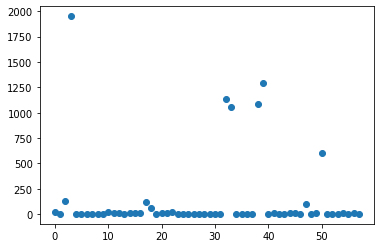

In [13]:
plt.scatter(range(df.shape[1]),[df[col].nunique() for col in df.columns])

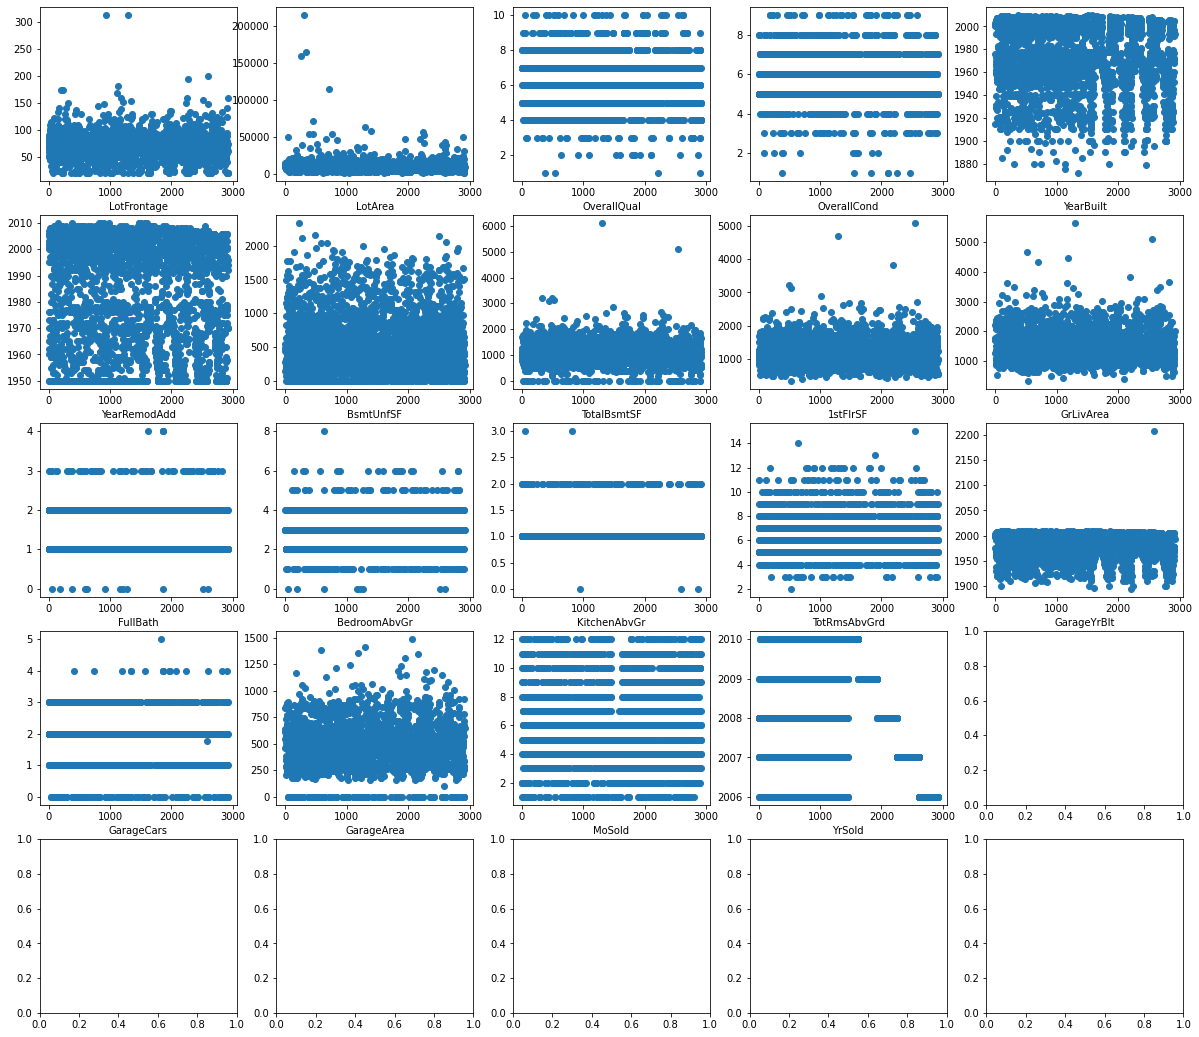

In [14]:
plots=len([col for col in df.select_dtypes(exclude='object').columns])
fig,ax = plt.subplots(int(cp.sqrt(plots)+1),int(cp.sqrt(plots)+1))
fig.set_size_inches(20.5, 18.5)
j=[i for i in cp.arange(int(cp.sqrt(plots)+1)).get() for j in cp.arange(int(cp.sqrt(plots)+1)).get()]
k=[j for i in cp.arange(int(cp.sqrt(plots)+1)).get() for j in cp.arange(int(cp.sqrt(plots)+1)).get()]
# ax.shape
for idx,col in enumerate(df.select_dtypes(exclude='object').columns):
#     print(k[idx],j[idx],type(k[idx]),type(j[idx]))
    ax[j[idx]][k[idx]].scatter(x=range(len(df)),y=df[col].to_array())
    ax[j[idx]][k[idx]].set_xlabel(col)

## ENCODING THE CATEGORICAL FEATURES WITH LABEL ENCODER

In [15]:
for col in df.select_dtypes(include='object').columns:
    enc=LabelEncoder()
    df[col]=cd.Series(enc.fit_transform(df[col]))
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,10,3,65.0,8450,1,3,3,0,4,0,...,1,2.0,548.0,4,4,2,2,2008,8,4
1,5,3,80.0,9600,1,3,3,0,2,0,...,1,2.0,460.0,4,4,2,5,2007,8,4
2,10,3,68.0,11250,1,0,3,0,4,0,...,1,2.0,608.0,4,4,2,9,2008,8,4
3,11,3,60.0,9550,1,0,3,0,0,0,...,2,3.0,642.0,4,4,2,2,2006,8,0
4,10,3,84.0,14260,1,0,3,0,2,0,...,1,3.0,836.0,4,4,2,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2,4,21.0,1936,1,3,3,0,4,0,...,2,0.0,0.0,4,4,2,6,2006,8,4
2915,2,4,21.0,1894,1,3,3,0,4,0,...,2,1.0,286.0,4,4,2,4,2006,8,0
2916,5,3,160.0,20000,1,3,3,0,4,0,...,2,2.0,576.0,4,4,2,9,2006,8,0
2917,14,3,62.0,10441,1,3,3,0,4,0,...,2,0.0,0.0,4,4,2,7,2006,8,4


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

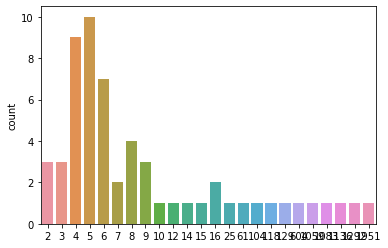

In [16]:
sns.countplot([df[col].nunique() for col in df.columns])

**Checking the distribution of features**

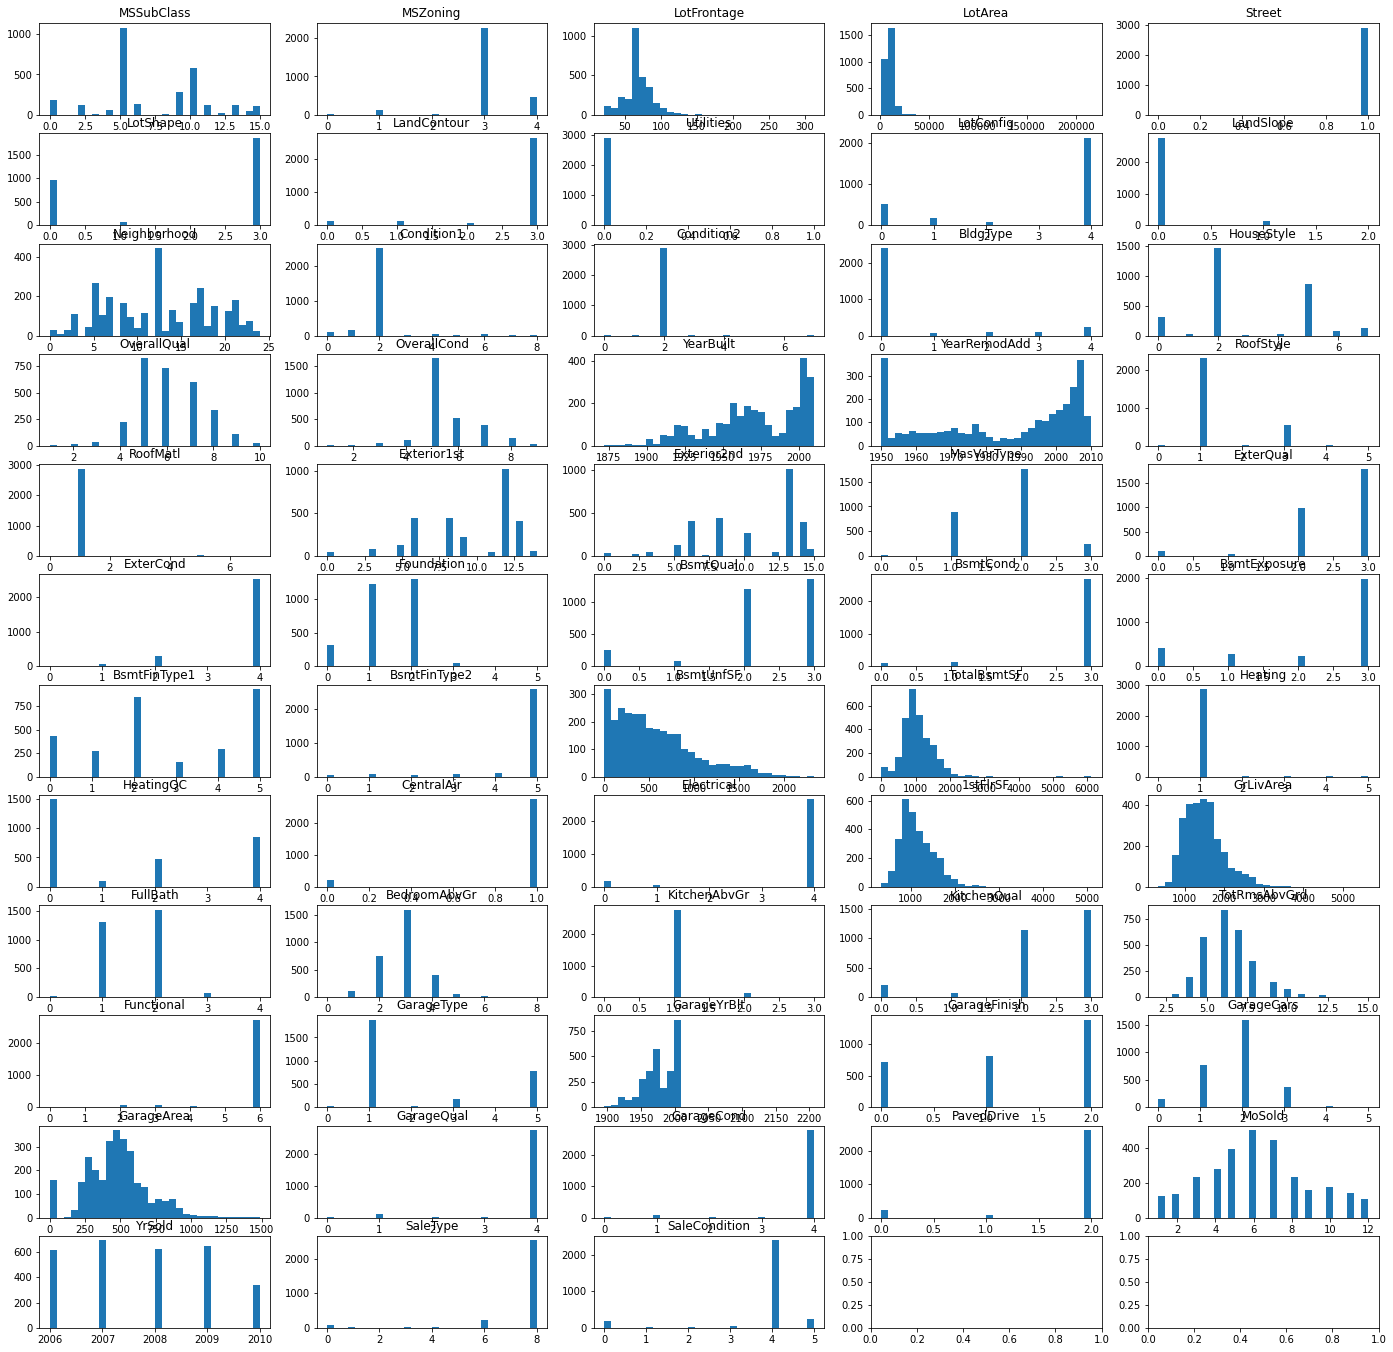

In [17]:
fig,ax = plt.subplots(12,5,figsize=(24,24))

for i in range(df.shape[1]):
    ax.flatten()[i].hist(df.iloc[:,i].to_pandas(),bins=30)
    ax.flatten()[i].set_title(df.columns[i])

In [18]:
df_train=df.iloc[:1460,:]
df_train['SalePrice']=Y
df_test = df.iloc[1460:,:]
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,10,3,65.0,8450,1,3,3,0,4,0,...,2.0,548.0,4,4,2,2,2008,8,4,208500
1,5,3,80.0,9600,1,3,3,0,2,0,...,2.0,460.0,4,4,2,5,2007,8,4,181500
2,10,3,68.0,11250,1,0,3,0,4,0,...,2.0,608.0,4,4,2,9,2008,8,4,223500
3,11,3,60.0,9550,1,0,3,0,0,0,...,3.0,642.0,4,4,2,2,2006,8,0,140000
4,10,3,84.0,14260,1,0,3,0,2,0,...,3.0,836.0,4,4,2,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,10,3,62.0,7917,1,3,3,0,4,0,...,2.0,460.0,4,4,2,8,2007,8,4,175000
1456,5,3,85.0,13175,1,3,3,0,4,0,...,2.0,500.0,4,4,2,2,2010,8,4,210000
1457,11,3,66.0,9042,1,3,3,0,4,0,...,1.0,252.0,4,4,2,5,2010,8,4,266500
1458,5,3,68.0,9717,1,3,3,0,4,0,...,1.0,240.0,4,4,2,4,2010,8,4,142125


## Checking the multicollinearity present in the dataset

<AxesSubplot:>

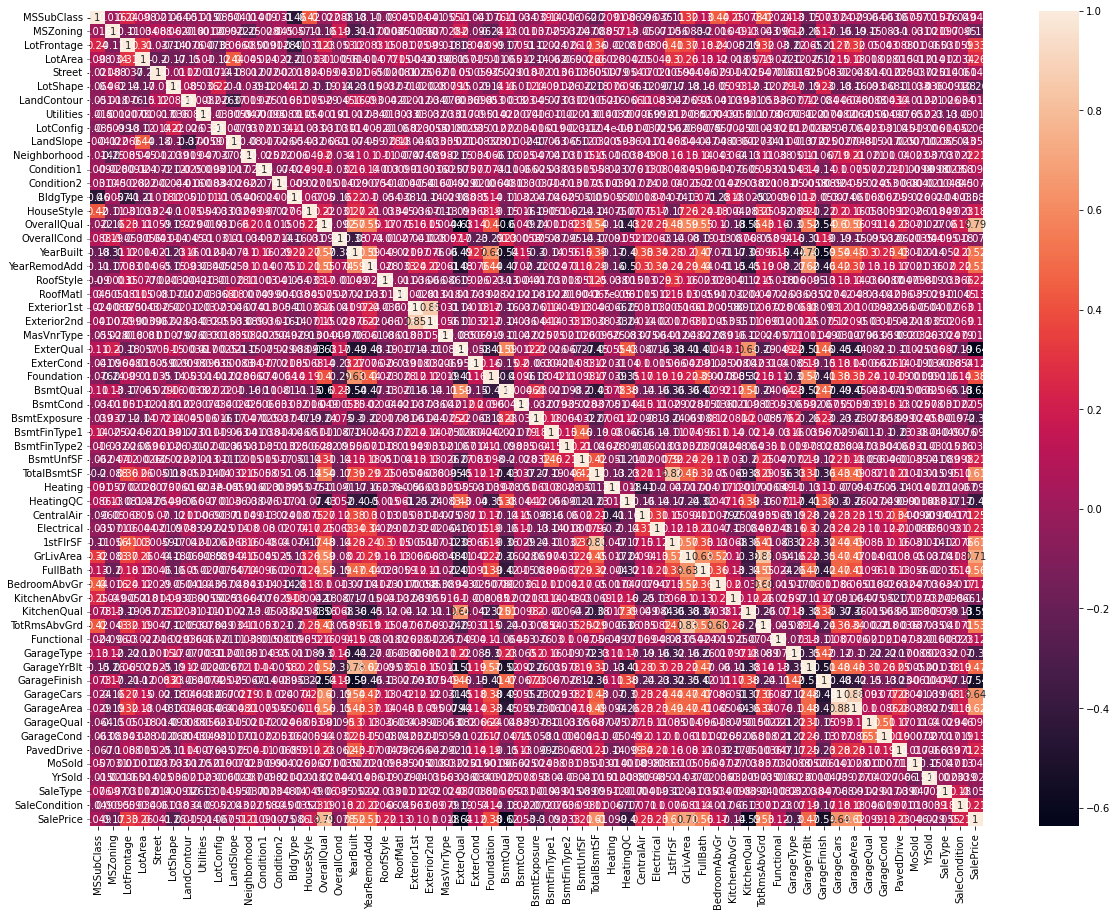

In [19]:
fig=plt.figure()
fig.set_size_inches(20, 15)
sns.heatmap(df_train.to_pandas().corr(),annot=True)

**Some features are highly correlated but most have distribution of mediocre correlation**

(array([  3.,   2.,   0.,   2.,   3.,   7.,   5.,  10.,  39.,  35.,  49.,
        100., 138., 186., 146., 156., 142., 102., 100.,  68.,  52.,  44.,
         22.,  24.,  12.,   4.,   3.,   3.,   1.,   2.]),
 array([10.46024211, 10.56271647, 10.66519084, 10.7676652 , 10.87013956,
        10.97261393, 11.07508829, 11.17756266, 11.28003702, 11.38251138,
        11.48498575, 11.58746011, 11.68993448, 11.79240884, 11.8948832 ,
        11.99735757, 12.09983193, 12.2023063 , 12.30478066, 12.40725502,
        12.50972939, 12.61220375, 12.71467812, 12.81715248, 12.91962684,
        13.02210121, 13.12457557, 13.22704994, 13.3295243 , 13.43199866,
        13.53447303]),
 <BarContainer object of 30 artists>)

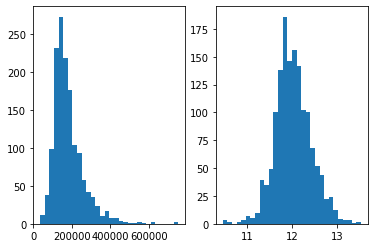

In [20]:
fig,ax = plt.subplots(1,2)
ax[0].hist(df_train.iloc[:,-1].to_pandas(),bins=30)
ax[1].hist(np.log(df_train.iloc[:,-1].to_pandas()),bins=30)

#### THE TARGET SHOWS A VERY CLOSE TO NORMAL DISTRIBUTION UPON LOG TRANSFORMATION. THIS WILL ALSO HANDLE OUTLIERS TO SOME EXTENT

In [21]:
X = df_train.iloc[:,:-1].values
y = cp.log(df_train.iloc[:,-1])
type(X),type(y)

(cupy._core.core.ndarray, cupy._core.core.ndarray)

## HYPERPARAMETERS THAT MAY BE USED FOR HYPERPARAMETER TUNING

In [22]:
params={'fit_intercept':[True,False],
        'algorithm' : ['svd', 'eig', 'qr', 'svd-qr', 'svd-jacobi']
        }
ridge_params={'alpha':[10**(-i) for i in range(0,10)],'fit_intercept':[True,False],
                                  'solver':['eig', 'svd']}
lasso_params={'alpha':[10**(-i) for i in range(0,10)],'fit_intercept':[True,False],
             'tol':[10**(-i) for i in range(2,5)]}
elastic_params={'alpha':[10**(-i) for i in range(-1,5)],
                'fit_intercept':[True,False],
                'l1_ratio':np.arange(0.2,0.9,0.1),
                'tol':[1e-5,1e-4,1e-3]}

#### CHECKING FOR A PRELIMINARY ANALYSIS FOR HOW THE REGRESSORS AND THEIR SOLVERS(IF PRESENT) PERFORM FOR SCORING WITH VARIOUS METRICS

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
y_train, y_test = y_train.astype('float64'), y_test.astype('float64')

print("Linear Regression")
for algo in params['algorithm']:
    reg=LinearRegression(algorithm=algo)
    reg.fit(X_train,y_train)
    y_pred=reg.predict(X_test)
    print(algo,reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))

print('\nRidge')
for algo in ridge_params['solver']:
    
    reg=Ridge(solver=algo)
    reg.fit(X_train,y_train)
    y_pred=reg.predict(X_test)
    print(algo,reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))
    
print('\nLasso')
reg=Lasso()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
print(reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))

print('\nElasticNet')
reg=ElasticNet()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
print(reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))

Linear Regression
svd 0.8789840325079913 0.8789840325079913 0.09985898978306924 0.01944220604839822
eig 0.878984032350959 0.878984032350959 0.0998589898624747 0.019442206073626754
qr 0.8789840325079812 0.8789840325079812 0.09985898978306589 0.019442206048399843
svd-qr -0.03743341914500409 -0.03743341914500409 0.32131611897007634 0.16667217322245823
svd-jacobi -0.03743341914483067 -0.03743341914483067 0.32131611897004814 0.1666721732224304

Ridge
eig -0.037338929489719286 -0.037338929489719286 0.3213060424013401 0.16665699268566164
svd -0.03733892926699256 -0.03733892926699256 0.3213060423608642 0.16665699264987874

Lasso
-0.020658430910694525 -0.020658430910694525 0.3142761188558059 0.1639771340101126

ElasticNet
-0.02760708440697157 -0.02760708440697157 0.31511642367986803 0.16509349208940874


In [24]:
df_test.shape

(1459, 58)

In [25]:
reg=LinearRegression(algorithm='qr')
reg.fit(X,y)

LinearRegression()

In [26]:
ids=cd.Series(df_test.index+1)
target=reg.predict(df_test)
df=cd.DataFrame()
df['Id']=ids
df['SalePrice']=np.exp(target,dtype='float64')
df

,Id,SalePrice
0,1461,116174.309836
1,1462,158747.203503
2,1463,169953.427189
3,1464,192314.642619
4,1465,191475.708407
...,...,...
1454,2915,95262.478909
1455,2916,86434.158001
1456,2917,141974.216538
1457,2918,126837.249547


In [27]:
df.to_pandas().to_csv('submission.csv',index=False)